# Weir: Water flowing over a low dam

https://en.wikipedia.org/wiki/Weir

In [1]:
import os
import sys
from collections import OrderedDict
sys.path.append("../")
import spatialpy
spatialpy.__file__
import matplotlib.pyplot as plt
import numpy
#%load_ext autoreload
#%autoreload 2

In [2]:
class Teleport(spatialpy.BoundaryCondition):
    def __init__(self):
        pass
    
    def expression(self):
        return """
        if(me->x[0] > system->xhi){
            me->x[0] = system->xlo + 0.55;
        }
        if(me->x[0] < system->xlo ){
            me->x[0] = system->xlo + 0.55;
        }
        if(me->x[1] > system->yhi){
            me->v[1]= 0.0;
            me->x[1]= system->yhi - 0.01;
        }
        me->x[2] = 0;
        me->rho = 2.5;
        """

In [3]:
class HardFloor(spatialpy.BoundaryCondition):
    def __init__(self):
        pass
    
    def expression(self):
        return """
        if(me->x[1] < 0.4){
            me->x[1] = 0.5;
            me->v[1] = 0.0;
        }
        """

In [4]:
class Bottom(spatialpy.Geometry):
    def __init__(self, y_lim):
        self.y_lim = y_lim
        
    def inside(self, point, on_boundary):
        if point[1] == self.y_lim:
            return True
        return False

In [5]:
class Water(spatialpy.Geometry):
    def __init__(self, x_lim, y_lim):
        self.x_lim = x_lim
        self.y_lim = y_lim
        
    def inside(self, point, on_boundary):
        if point[1] > self.y_lim[0] and point[1] < self.y_lim[1] and \
                    point[0] > self.x_lim[0] and point[0] < self.x_lim[1]:
            return True
        return False

In [6]:
class Step(spatialpy.Geometry):
    def __init__(self, x_lim, y_lim):
        self.x_lim = x_lim
        self.y_lim = y_lim
        
    def inside(self, point, on_boundary):
        if point[0] >= self.x_lim[0] and point[0] <= self.x_lim[1] and \
                    point[1] > self.y_lim[0] and point[1] < self.y_lim[1]:
            return True
        return False

In [7]:
class weir(spatialpy.Model):
    GROUND = "Ground"
    WATER = Water.__name__

    def __init__(self, model_name="weir"):
        spatialpy.Model.__init__(self, model_name)

        xmax = 35.1
        ymax = 10.1
        water_mass = 1.0
        wall_mass  = 1.0

        # Construct mesh for backward facing step
        domain = spatialpy.Domain(0, xlim=(0, xmax), ylim=(0, ymax), zlim=(0, 0), gravity=[0, -1, 0])
        delta_x = 0.2
        domain.fill_with_particles(
            Bottom(0), delta_x, ymax=0, type_id=self.GROUND, mass=wall_mass, vol=1.0, nu=1.0, fixed=True
        )
        water = Water((1, 8), (1, 8))
        domain.fill_with_particles(
            water, delta_x * 2, xmin=1, xmax=8, ymin=1, ymax=8,
            type_id=self.WATER, mass=water_mass, vol=1.0, nu=1.0, fixed=False
        )
        step = Step((10, 15), (0, 5))
        domain.fill_with_particles(
            step, delta_x, xmin=10, xmax=15, ymax=5, type_id=self.GROUND,
            mass=wall_mass, vol=1.0, nu=1.0, fixed=True
        )
        self.add_domain(domain)
        
        # Teleport particles back to start to simulate flow
        self.add_boundary_condition(Teleport())
        self.add_boundary_condition(HardFloor())

        self.staticDomain = False

        # Define time parameters
        self.timespan(numpy.linspace(0, 50, num=101), timestep_size=1e-3)

In [8]:
model = weir()

In [9]:
from spatialpy import Solver
sol = Solver(model, debug_level=0)
%time sol.compile()

CPU times: user 14.6 ms, sys: 3.75 ms, total: 18.3 ms
Wall time: 544 ms


In [10]:
%time result = sol.run()

CPU times: user 6.39 ms, sys: 5.09 ms, total: 11.5 ms
Wall time: 8min 4s


In [37]:
def mpl_plot_property(t_ndx=0):
    import matplotlib.pyplot as plt

    points, data = result.read_step(t_ndx)

    d = data["type"]

    plt.figure(figsize=(6.4, 4.8))
    plt.scatter(points[:, 0], points[:, 1], c=d)
    plt.axis('scaled')
    plt.grid(linestyle='', linewidth=1)
    plt.plot()
    return

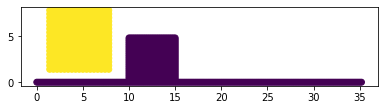

In [38]:
mpl_plot_property(0)

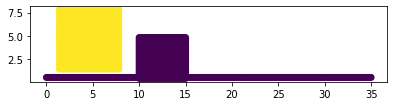

In [39]:
mpl_plot_property(1)

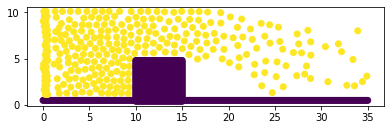

In [40]:
mpl_plot_property(10)

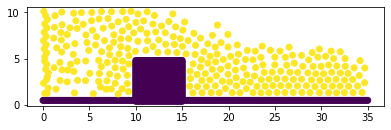

In [41]:
mpl_plot_property(99)

In [16]:
result.plot_property("type", animated=True, t_duration=0,f_duration=0)